In [54]:
from typing import Any
import matplotlib.pyplot as plt
import numpy as np
import gravity
import leapint

In [91]:
from typing import Any

import numpy as np

#The following functions assume the plane of orbit is the x, y axis, with positive 

def initmice(R_min:float, mass:float, time_unit:float, wA:float, wB:float, iA:float, iB:float, e:float, epsilon:float) -> tuple :

    #Disk Inits in galaxy frame
    posA, velA = initdisk(R_min, mass, epsilon)
    posB, velB = initdisk(R_min, mass, epsilon)

    #Rotate galaxies according to angles
    posA_rot, velA_rot = rotdisk(posA, velA, iA, -1)
    posB_rot, velB_rot = rotdisk(posB, velB, iB, 1)

    #Translate each galacy so COM is at origin
    Rapoc = R_min*(1+e)/(1-e)
    pos_m = np.array([[0, -Rapoc, 0], [0, Rapoc, 0]])

    posA_CM = posA_rot+pos_m[0]
    posB_CM = posB_rot+pos_m[1]

    #Set the velocities of the each galaxy TODO
    vel_m = np.array([[0, 0, 0], [0, 0, 0]])

    velA_CM = velA_rot+vel_m[0]
    velB_CM = velB_rot+vel_m[1]

    pos_CM = np.concatenate((posA_CM, posB_CM), axis=0)
    vel_CM = np.concatenate((velA_CM, velB_CM), axis=0)

    return pos_m, vel_m, pos_CM, vel_CM

    
def initdisk(R_min:float, mass:float, epsilon:float) ->tuple:
    pos = np.zeros((297, 3))
    vel = np.zeros((297, 3))
    curr = 0
    for i in range(0, 11):
        num_particles = 3*i + 12
        radius = (0.05*i + 0.2)*R_min
        for j in range(0, num_particles):
            angle = (2.0*np.pi /num_particles)*j
            pos[curr] = (radius*np.cos(angle), radius*np.sin(angle), 0)
            velmag = np.sqrt(mass*radius/(radius**2+epsilon**2))
            veldirnorm = np.array([-1*pos[curr, 1], pos[curr, 0], 0]) / np.sqrt(pos[curr, 1]**2+pos[curr, 0]**2)
            vel[curr] = velmag*veldirnorm
            curr+=1
    return pos, vel

def rotdisk(pos: np.ndarray[float, Any], vel: np.ndarray[float, Any], i:float, n:float) -> tuple:

    #Adjust angle based on whethere rotation is around postive or negative x axis
    iadj = n*i*-1
    #print(iadj)
    #Rotate positions and velocity by -i around positive
    #Create Rot Matrix around x axis
    rot = np.array([[1, 0, 0], [0, np.cos(iadj), -1*np.sin(iadj)], [0, np.sin(iadj), np.cos(iadj)]])
    #print(rot)
    pos_rot = (rot@pos.transpose()).transpose()
    vel_rot = (rot@vel.transpose()).transpose()
    #print(pos)
    #print(pos_rot)
    return pos_rot, vel_rot



In [120]:
pos_m, vel_m, pos_CM, vel_CM = initmice(1, 1, 1, 1, 1, np.pi/12, np.pi/3, 0.6, 0)

(594, 3)

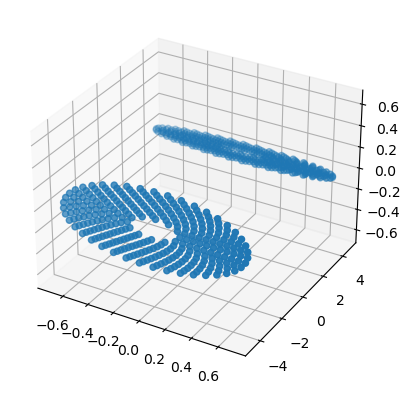

In [121]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([-0.7, 0.7])
ax.scatter(pos_CM.transpose()[0], pos_CM.transpose()[1], pos_CM.transpose()[2])
np.shape(pos_CM)